In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import cftime
import datetime
from datetime import date
from matplotlib import pyplot
from matplotlib import colors
from matplotlib import font_manager
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import numpy
import pandas
import xarray as xr

In [2]:
# Define Directories
Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Publish/Storm_Tracking/'
NetCDF_Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Publish/Large_Scale_Data/'
Output_Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Publish/Figures/'

In [3]:
# Open File
def Open_File(File):
    DF = pandas.read_csv(File)
    DF = DF.drop("Unnamed: 0", axis=1)
    return (DF)

In [4]:
# Open Each File
def Files_Open(Model, Diri, Subset):
    Data_DF = Open_File(Diri+Model+'_Data_'+Subset+'_Output.csv')
    ET_DF = Open_File(Diri+Model+'_ET_'+Subset+'_Output.csv')
    Codes_DF = Open_File(Diri+Model+'_Codes_Output.csv')
# Edit Time Format
    Time, Begin_Time, Compl_Time, Trop_Peak_Time, Peak_Time, Genesis_Time = [], [], [], [], [], []
    for i in range(len(Data_DF)):
        Time.append(Datetime(Data_DF["Time(Z)"][i]))
    for j in range(len(ET_DF)):
        Begin_Time.append(Datetime(ET_DF["ET Begin Time"][j]))
        Compl_Time.append(Datetime(ET_DF["ET Complete Time"][j]))
        Trop_Peak_Time.append(Datetime(ET_DF["Trop Peak Time"][j]))
        Peak_Time.append(Datetime(ET_DF["Peak Time"][j]))
        Genesis_Time.append(Datetime(ET_DF["Genesis Time"][j]))
    Data_DF["Time(Z)"] = Time
    ET_DF["ET Begin Time"] = Begin_Time
    ET_DF["ET Complete Time"] = Compl_Time
    ET_DF["Trop Peak Time"] = Trop_Peak_Time
    ET_DF["Peak Time"] = Peak_Time
    ET_DF["Genesis Time"] = Genesis_Time
    return (Data_DF, ET_DF, Codes_DF)

In [5]:
# Edit Time Format
def Datetime(Time):
    try:
        New_Time = datetime.datetime.strptime(Time, '%Y-%m-%d %H:%M:%S')
    except:
        New_Time = numpy.nan
    return (New_Time)

In [6]:
# Create Phase Distribution Bins
def Create_Bins(Min, Max, Bin_Width):
    Bins = numpy.arange(Min, Max+Bin_Width, Bin_Width)
    return (Bins)
Lat_Bins = Create_Bins(10,60,5)
Lon_Bins = Create_Bins(-100,20,5)

In [7]:
# Number of Years For Each Climate Scenario
Num_Years = numpy.array([90,93,93])

In [8]:
# Find a Specific Storm Within the DataFrame
def Find_Storm(DF, Code):
    DF_Storm = DF[DF["Code"] == Code].reset_index()
    return (DF_Storm)

In [9]:
# Function to Find Distance Between Two Points
def Find_Distance(y1, y2, x1, x2):
    Start_Lat = y1 * numpy.pi / 180
    End_Lat = y2 * numpy.pi / 180
    Start_Lon = x1 * numpy.pi / 180
    End_Lon = x2 * numpy.pi / 180
    Lat_Diff = End_Lat - Start_Lat
    Lon_Diff = End_Lon - Start_Lon
    Earth_Rad = 6378
    Distance = 2 * Earth_Rad * numpy.sqrt((numpy.sin(Lat_Diff/2))**2 + \
    numpy.cos(Start_Lat) * numpy.cos(End_Lat) * (numpy.sin(Lon_Diff/2))**2)
    return (Distance)

In [10]:
# Open Files
Control_Data, Control_ET, Control_Codes = Files_Open("Control", Diri, "SubsetB")
RCP45_Data, RCP45_ET, RCP45_Codes = Files_Open("RCP45", Diri, "SubsetB")
RCP85_Data, RCP85_ET, RCP85_Codes = Files_Open("RCP85", Diri, "SubsetB")

In [11]:
# Months Name
Months_Name = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jun-Aug', 'Sep-Nov', 'Dec-May', 'Annual']

In [12]:
# Create Function to Open Monthly Files
def Open_Monthly_File(Model):
    DS_Dict = {}
    for i in range(len(Months_Name)):
        File_Name = str(Model+'_Output_'+Months_Name[i]+'.nc')
        Month_DS = xr.open_dataset(NetCDF_Diri + File_Name)
        DS_Dict[Months_Name[i]] = Month_DS
        print (i)
    return (DS_Dict)

In [13]:
# Open Monthly Files
Control_DS_Dict = Open_Monthly_File("Control")
RCP45_DS_Dict = Open_Monthly_File("RCP45")
RCP85_DS_Dict = Open_Monthly_File("RCP85")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [14]:
# Create Function to Calculate Eady Growth Rate
def Eady_Growth_Rate(DS_Dict, Month):
# Define Constants and Variables
    P0 = 100000
    Rd = 287
    cp = 1005
    Temp = DS_Dict[Month]['T']
    Plev = DS_Dict[Month]['plev']
    Lat = DS_Dict['Sep-Nov']['lat']
    Z = DS_Dict[Month]['Z3']
    U = DS_Dict[Month]['U']
    V = DS_Dict[Month]['V']
#
# Calculate Potential Temperature
    Theta = Temp * (P0 / Plev) ** (Rd/cp)
#
# Calculate Coriolis Parameter
    f = 2 * 7.2921 * 10**-5 * numpy.sin(Lat / 180 * numpy.pi)
#
# Calculate Brunt Vaisala Frequency
    dTheta = Theta.diff(dim='plev')
    dZ = Z.diff(dim='plev')
    Theta_Mid = (Theta.isel({'plev': slice(0, -1)}) + Theta.isel({'plev': slice(1, None)})) / 2
    N2 = (dTheta / dZ) * 9.81 / Theta_Mid
    N2_Safe = N2.where(N2 > 0)
    N = numpy.sqrt(N2_Safe)
#
# Calculate Vertical Gradient of Geostrophic Wind
    dU = U.diff(dim='plev')
    dV = V.diff(dim='plev')
    dZ = Z.diff(dim='plev')
    dU_dZ = numpy.sqrt((dU / dZ) ** 2 + (dV / dZ) ** 2)
#
# Calculate Eady Growth Rate
    Sigma = 0.31 * numpy.abs(dU_dZ) * f / N
#
# Convert to Day^-1
    Sigma_Day = Sigma * 24 * 60 * 60
    Sigma_Day
    return (Sigma_Day)

In [15]:
# Create Function For Plotting Contour Maps of Eady Growth Rate
def Eady_Contour_Plot(Control_DS_Dict, RCP45_DS_Dict, RCP85_DS_Dict, Months, Plev, \
Bounds, Colours, Diff_Bounds, Diff_Colours, Line_Bounds, Label, Label_Unit, Diff_Plot, Savefig, Figname):
# Create Fig
    Fig = pyplot.figure(figsize=(18,20))
#
# Produce Dataset
    for i in range(len(Months)):
        Month = Months[i]
        Control_Eady = Eady_Growth_Rate(Control_DS_Dict, Month).sel(plev=Plev, lon=slice(-100,-15), lat=slice(0,60))
        RCP45_Eady = Eady_Growth_Rate(RCP45_DS_Dict, Month).sel(plev=Plev, lon=slice(-100,-15), lat=slice(0,60))
        RCP85_Eady = Eady_Growth_Rate(RCP85_DS_Dict, Month).sel(plev=Plev, lon=slice(-100,-15), lat=slice(0,60))
        RCP45_Eady_Diff = RCP45_Eady - Control_Eady
        RCP85_Eady_Diff = RCP85_Eady - Control_Eady
#
# Plot Control
        Axis = Fig.add_subplot(4,3,i+1, projection=ccrs.PlateCarree())
        Plot_Contour_Map(Axis, Control_Eady, Bounds, Colours)
        Plot_Formatting(Axis, str("Control (" + Month + ")"))
        Letter_Label(Axis, i)
#
# Colour Bar
        if i == 1:
            C_Map = mcolors.LinearSegmentedColormap.from_list(Label, Colours, N=len(Colours))
            Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='max')
            Cax = Axis.inset_axes([0.02, -0.10, 0.96, 0.02], transform=Axis.transAxes)
            Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', \
            cax=Cax, label=str(Label+" "+Label_Unit), shrink=0.7)
#
# Plot RCP4.5 or RCP4.5-Control
        Axis = Fig.add_subplot(4,3,i+4, projection=ccrs.PlateCarree())
        if Diff_Plot == False:
            Plot_Contour_Map(Axis, RCP45_Eady, Bounds, Colours)
            Plot_Formatting(Axis, str("RCP4.5 (" + Month + ")"))
        else:
            Plot_Contour_Map(Axis, RCP45_Eady_Diff, Diff_Bounds, Diff_Colours)
            Plot_Formatting(Axis, str("RCP4.5 - Control (" + Month + ")"))
#
# Colour Bar For Diff Plots
            if i == 1:
                C_Map = mcolors.LinearSegmentedColormap.from_list(Label, Diff_Colours, N=len(Diff_Colours))
                Norm = mcolors.BoundaryNorm(Diff_Bounds, C_Map.N, extend='both')
                Cax = Axis.inset_axes([0.02, -0.10, 0.96, 0.02], transform=Axis.transAxes)
                Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', \
                cax=Cax, label=str(Label+" Difference "+Label_Unit), shrink=0.7)
        Letter_Label(Axis, i+3)
#
# Plot RCP8.5 or RCP8.5-Control
        Axis = Fig.add_subplot(4,3,i+7, projection=ccrs.PlateCarree())
        if Diff_Plot == False:
            Plot_Contour_Map(Axis, RCP85_Eady, Bounds, Colours)
            Plot_Formatting(Axis, str("RCP8.5 (" + Month + ")"))
        else:
            Plot_Contour_Map(Axis, RCP85_Eady_Diff, Diff_Bounds, Diff_Colours)
            Plot_Formatting(Axis, str("RCP8.5 - Control (" + Month + ")"))
        Letter_Label(Axis, i+6)
#
# Plot Contour Lines
        Axis = Fig.add_subplot(4,3,i+10, projection=ccrs.PlateCarree())
        Plot_Contour_Lines(Axis, Control_Eady, Line_Bounds, 'limegreen')
        Plot_Contour_Lines(Axis, RCP45_Eady, Line_Bounds, 'darkorange')
        Plot_Contour_Lines(Axis, RCP85_Eady, Line_Bounds, 'red')
        Plot_Formatting(Axis, str(Label + " (" + Month + ")"))
        Letter_Label(Axis, i+9)
        Add_Legend(Axis, i, 1, 1)
#
# Save Fig
    Fig.tight_layout()
    if Savefig == True:
        Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

In [16]:
# Plotting Contour Map
def Plot_Contour_Map(Axis, DS, Bounds, Colours):
    pyplot.contourf(DS['lon'], DS['lat'], DS, levels=Bounds, colors=Colours, extend='both')

In [17]:
# Plotting Contour Map
def Plot_Contour_Lines(Axis, DS, Bounds, Colour):
    Contours = Axis.contour(DS['lon'], DS['lat'], DS, levels=Bounds, colors=Colour, \
    linestyles=['solid', 'dashed', 'dotted'])
    Axis.clabel(Contours, fmt="%.2f", fontsize=10)

In [18]:
# Formatting
def Plot_Formatting(Axis, Title):
    Axis.coastlines(linewidth=0.5)
    Axis.add_feature(cfeature.BORDERS, linewidth=0.5)
    Axis.add_feature(cfeature.STATES, linewidth=0.3)
    x_Min, x_Max, y_Min, y_Max = -100, -15, 0, 60
    x_Axis = Create_Bins(x_Min, x_Max, 10)
    y_Axis = Create_Bins(y_Min, y_Max, 10)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    Axis.set_xlim(x_Min,x_Max)
    Axis.set_ylim(y_Min,y_Max)
    Axis.set_title(Title, fontsize=18)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')

In [19]:
# Add Legend
def Add_Legend(Axis, i, i_Loc, Loc):
    if i == i_Loc:
        Axis.plot([-728,-728], [-728,-728], c='limegreen', label='Control')
        Axis.plot([-728,-728], [-728,-728], c='darkorange', label='RCP4.5')
        Axis.plot([-728,-728], [-728,-728], c='red', label='RCP8.5')
        pyplot.legend(loc=Loc, fontsize=15)

In [20]:
# Define Colours and Bounds
# Eady Growth Rate
Eady_Colours = ['lightskyblue', 'deepskyblue', 'lightseagreen', 'limegreen', 'greenyellow', \
'yellow', 'orange', 'darkorange', 'orangered', 'red']
Eady_Bounds = numpy.array([0,0.05,0.1,0.15,0.2,0.25,0.3,0.4,0.5,0.6])
Eady_Diff_Colours = ['navy', 'mediumblue', 'dodgerblue', 'deepskyblue', 'cyan', 'white', \
'gold', 'orange', 'darkorange', 'orangered', 'red']
Eady_Diff_Bounds = numpy.array([-0.2,-0.15,-0.1,-0.05,-0.01,0.01,0.05,0.1,0.15,0.2])
Eady_Lines_Bounds = numpy.array([0.15,0.25,0.5])

In [21]:
# Letter Labels
def Letter_Label(Axis, Plot):
    Fig_Labels = ['(a)','(b)','(c)','(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)', '(k)', '(l)']
    Axis.text(0.04, 0.95, str(Fig_Labels[int(Plot)]), ha='center', va='center', \
    transform=Axis.transAxes, fontdict={'size':24},color='black')

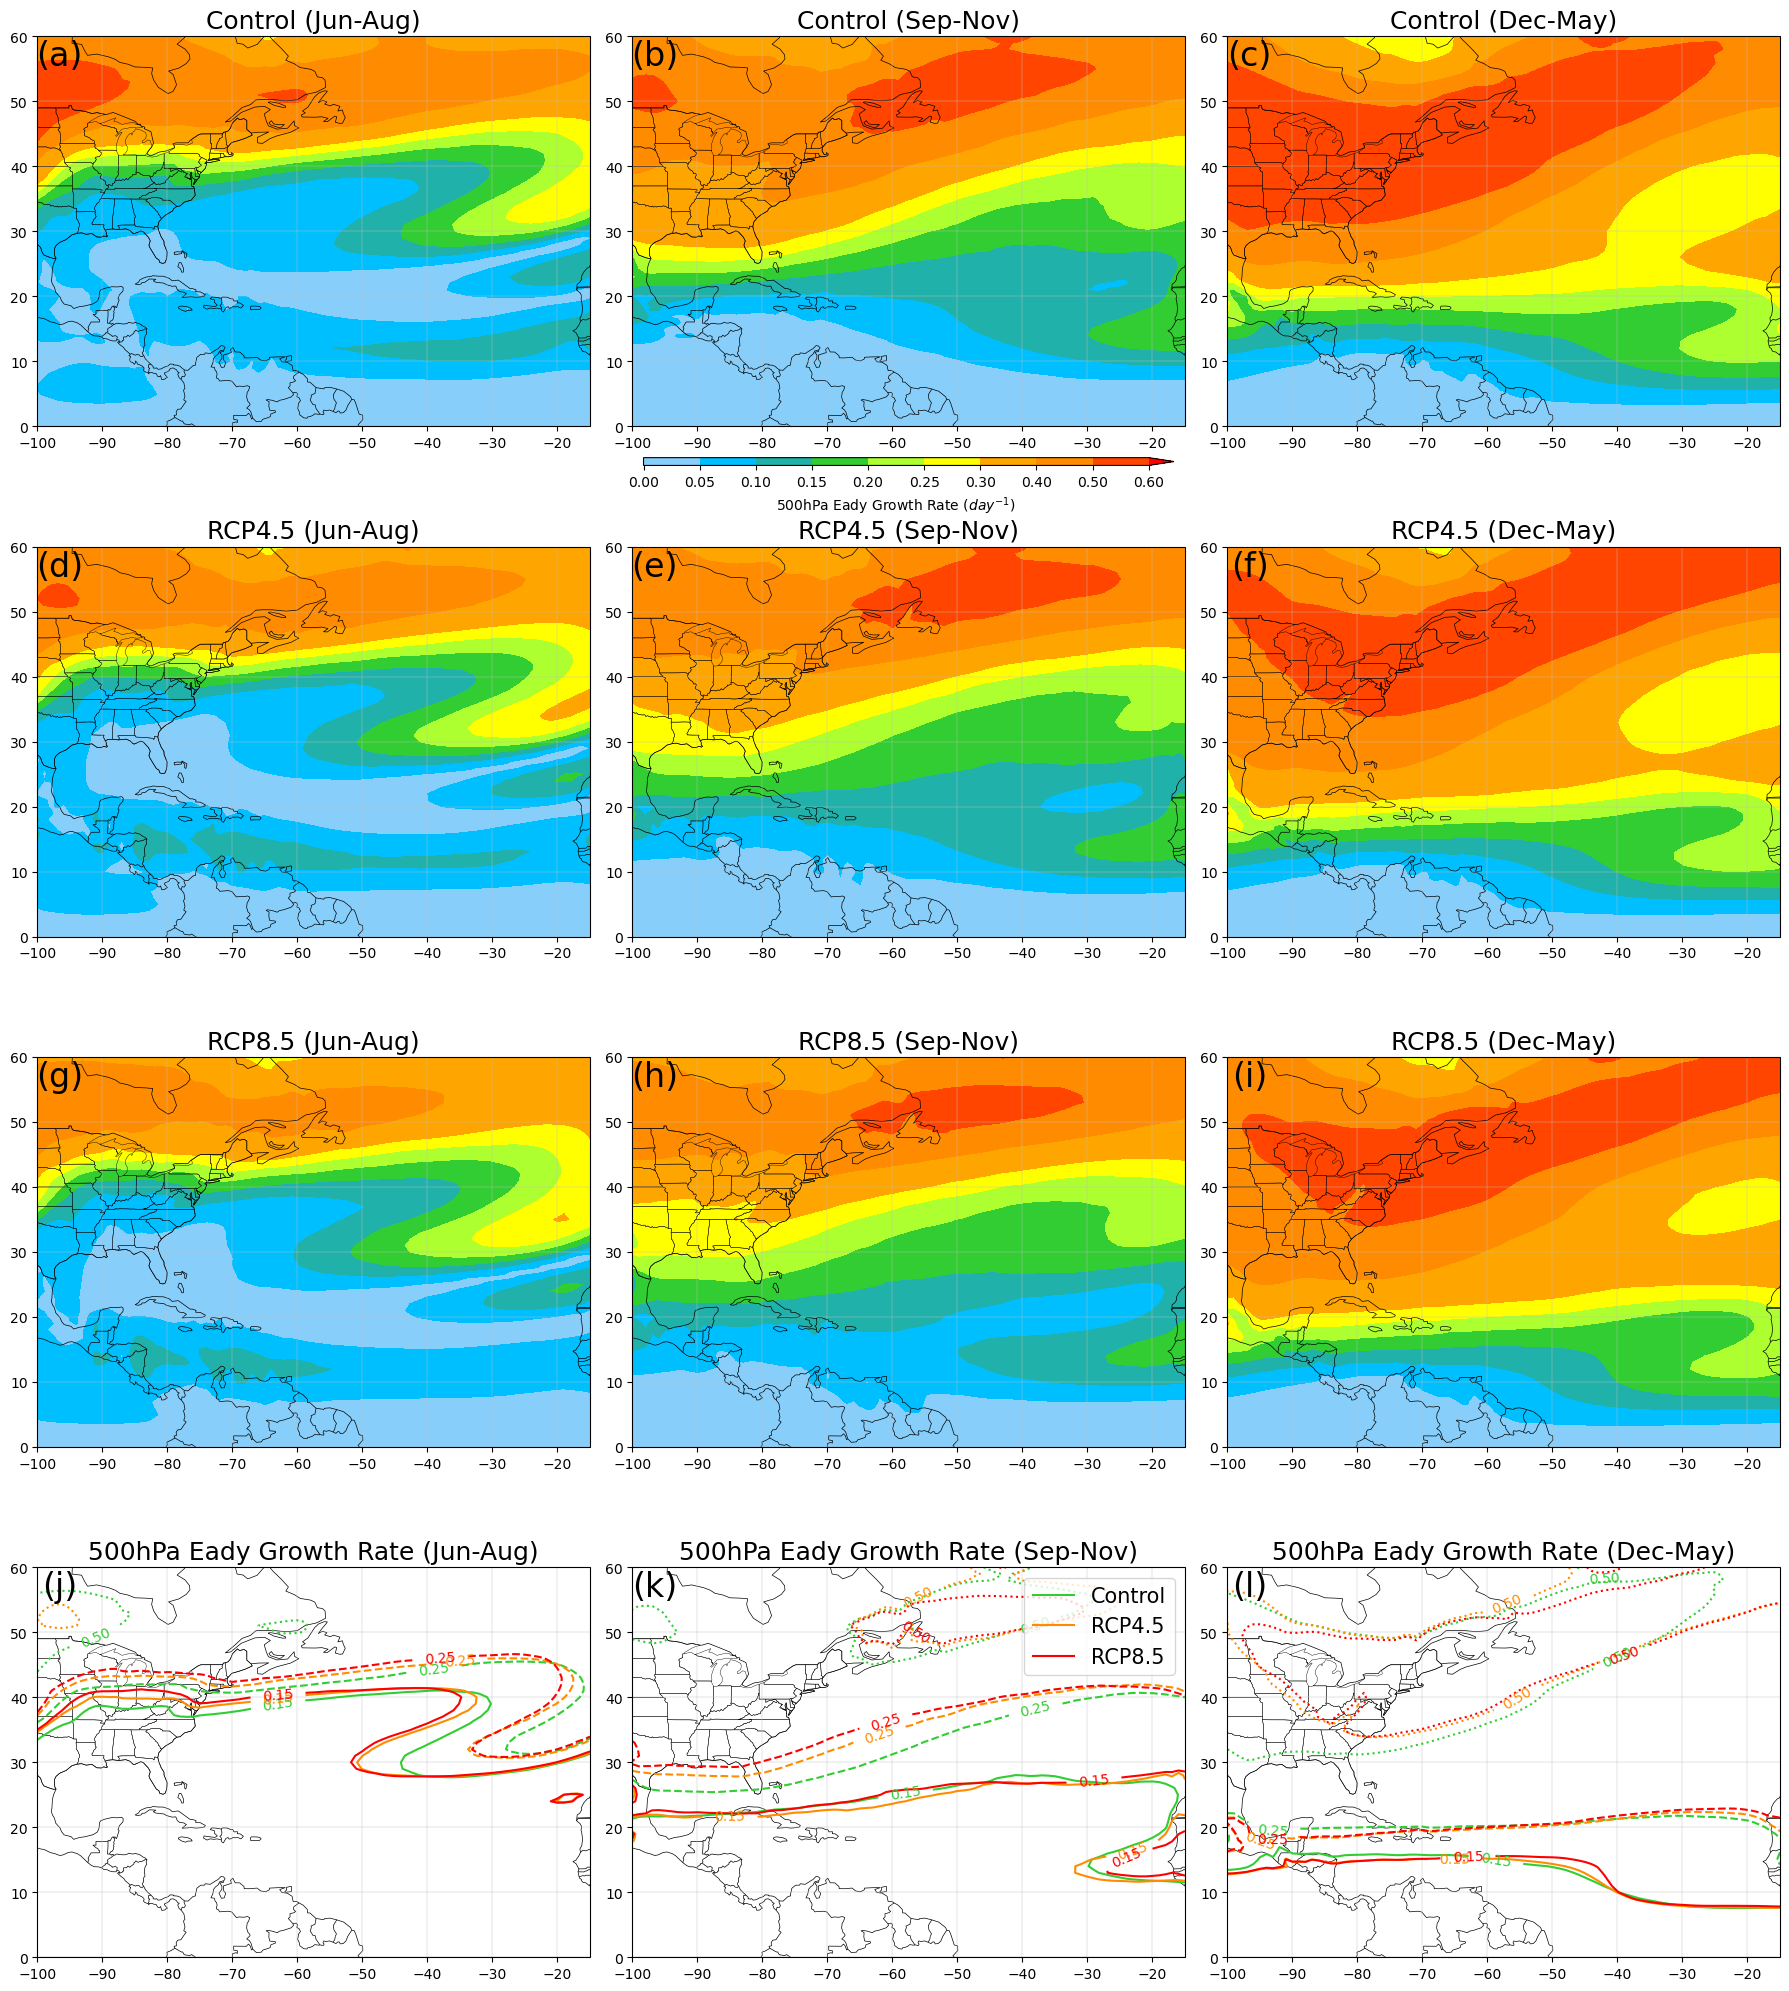

In [22]:
# Figure B16
# Plot 500hPa Eady Growth Rate
Months = ['Jun-Aug', 'Sep-Nov', 'Dec-May']
Plev = 50000
Bounds, Colours = Eady_Bounds, Eady_Colours
Diff_Bounds, Diff_Colours = Eady_Diff_Bounds, Eady_Diff_Colours
Line_Bounds = Eady_Lines_Bounds
Label, Label_Unit = '500hPa Eady Growth Rate', '($ day ^{-1} $)'
Diff_Plot = False
Savefig = True
Figname = 'Figure_B16.png'
Eady_Contour_Plot(Control_DS_Dict, RCP45_DS_Dict, RCP85_DS_Dict, Months, Plev, \
Bounds, Colours, Diff_Bounds, Diff_Colours, Line_Bounds, Label, Label_Unit, Diff_Plot, Savefig, Figname)

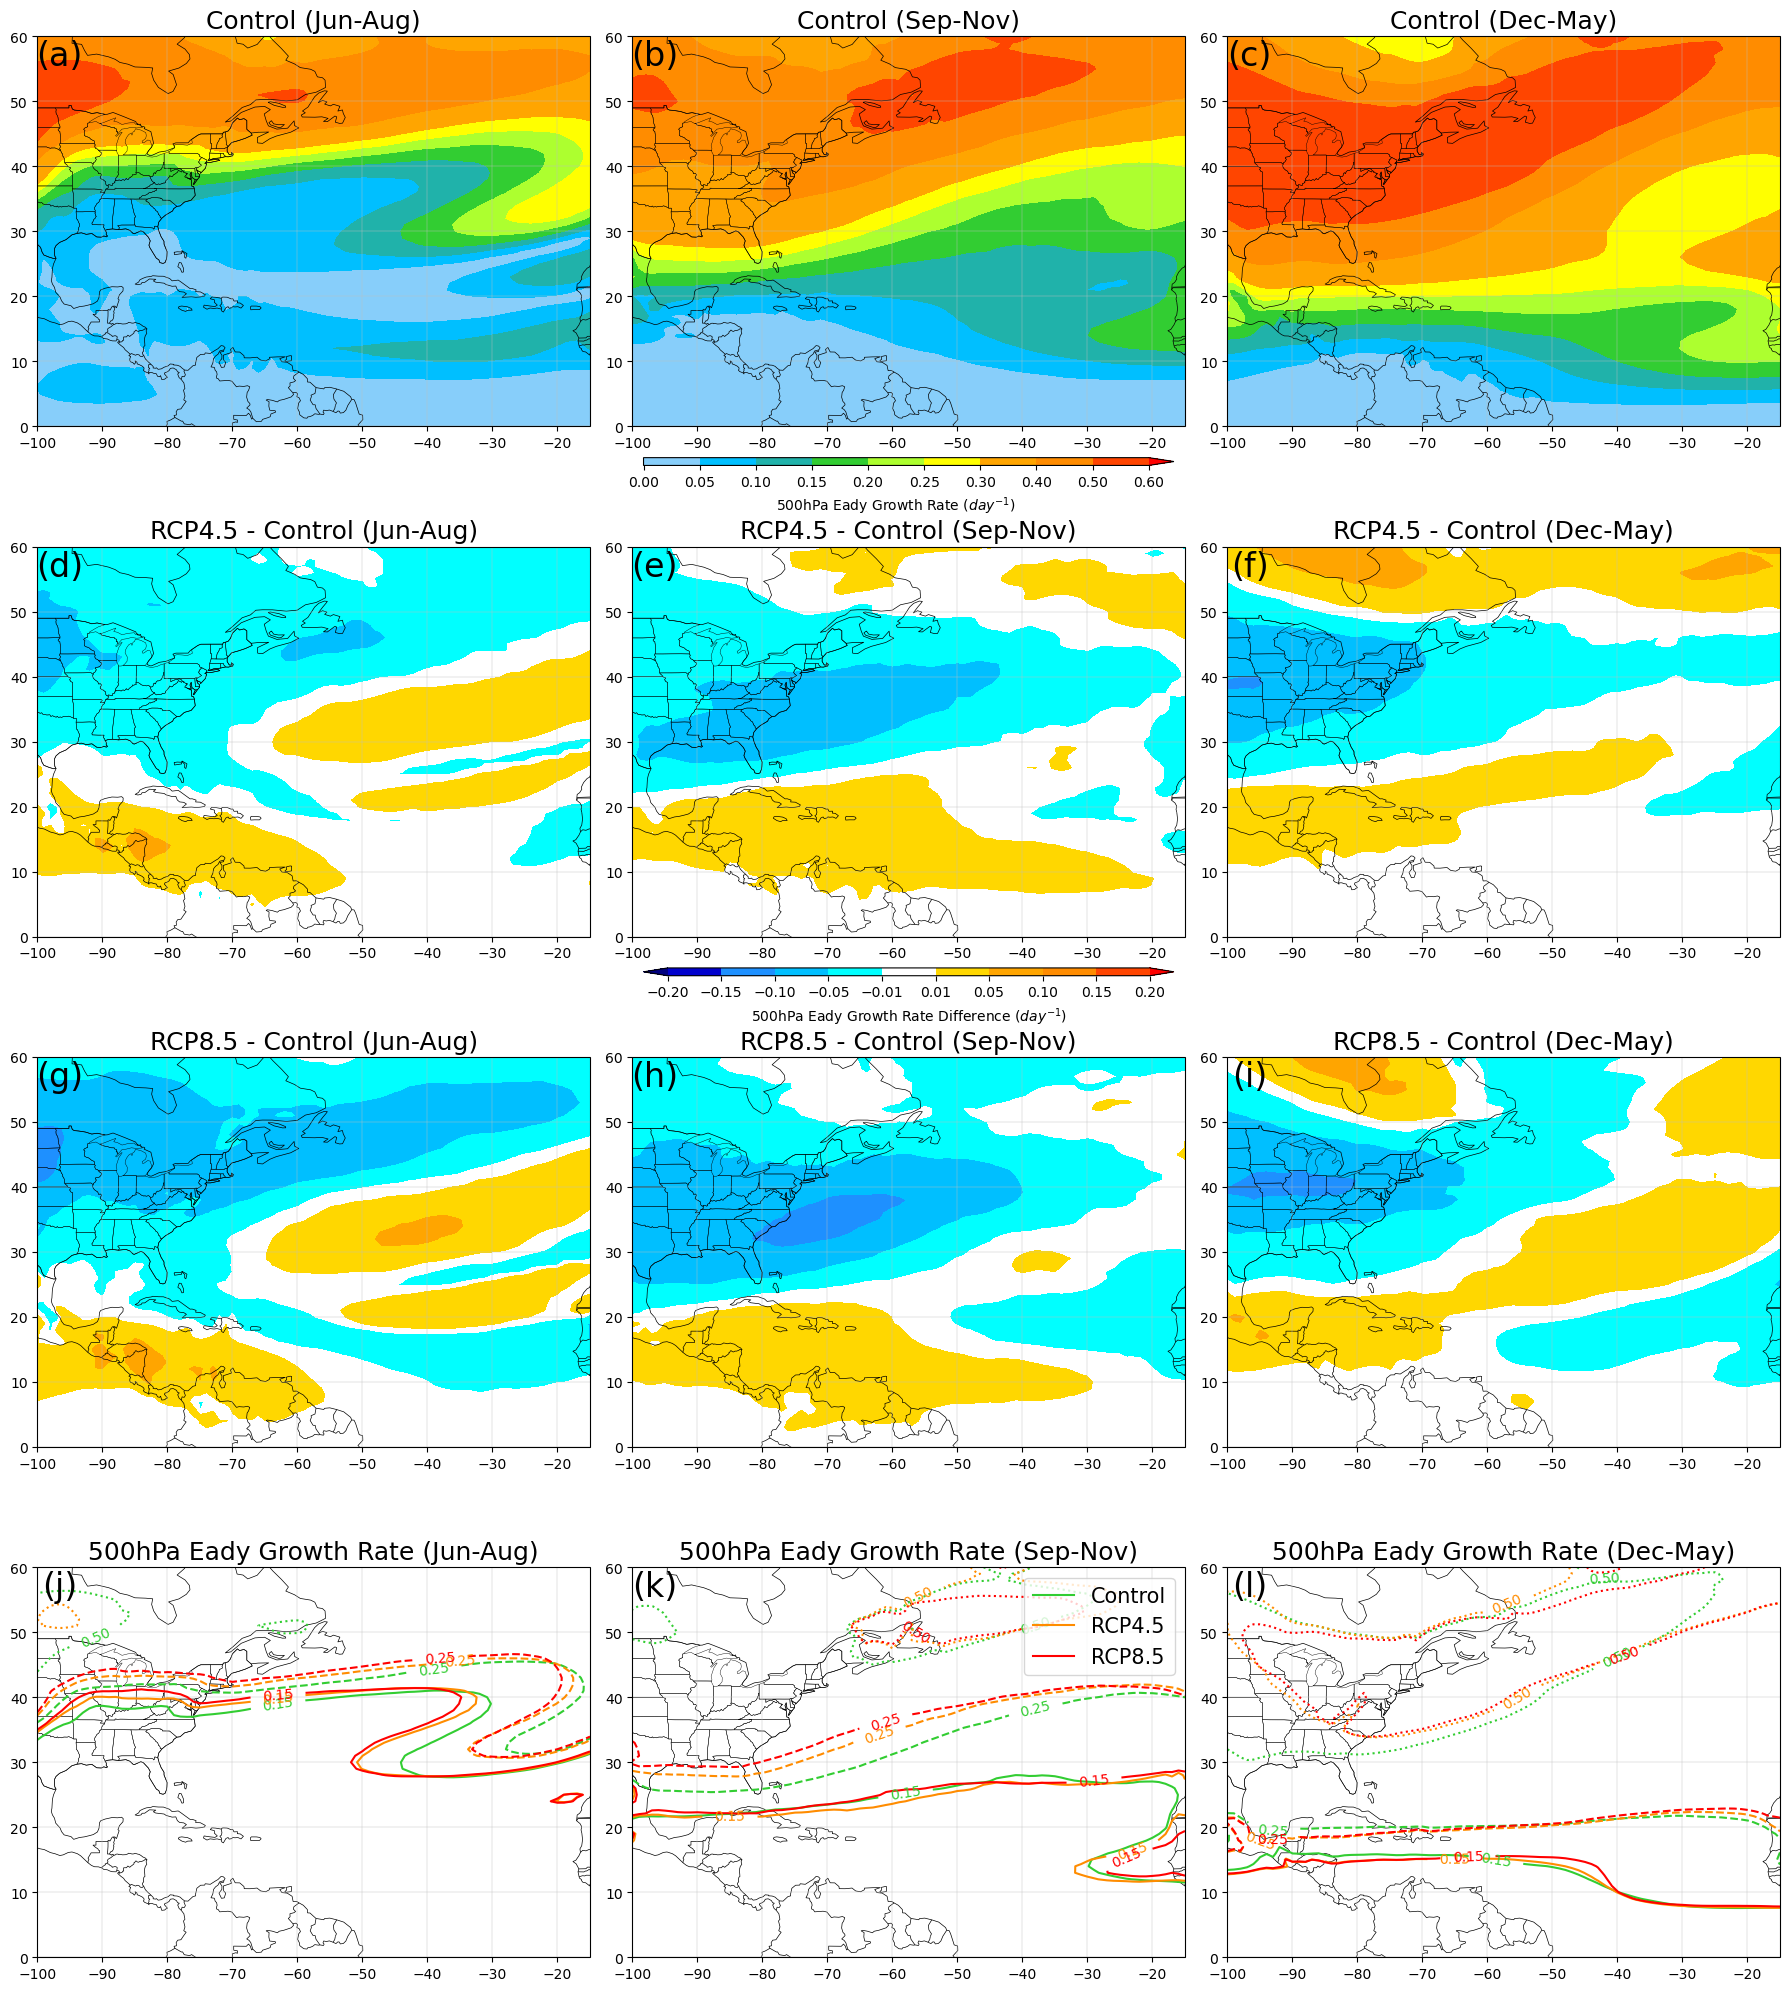

In [23]:
# Figure 16
# Plot 500hPa Eady Growth Rate Difference
Months = ['Jun-Aug', 'Sep-Nov', 'Dec-May']
Plev = 50000
Bounds, Colours = Eady_Bounds, Eady_Colours
Diff_Bounds, Diff_Colours = Eady_Diff_Bounds, Eady_Diff_Colours
Line_Bounds = Eady_Lines_Bounds
Label, Label_Unit = '500hPa Eady Growth Rate', '($ day ^{-1} $)'
Diff_Plot = True
Savefig = True
Figname = 'Figure_16.png'
Eady_Contour_Plot(Control_DS_Dict, RCP45_DS_Dict, RCP85_DS_Dict, Months, Plev, \
Bounds, Colours, Diff_Bounds, Diff_Colours, Line_Bounds, Label, Label_Unit, Diff_Plot, Savefig, Figname)